<a href="https://colab.research.google.com/github/akk-026/quora-duplicate-question-pairs/blob/main/Copy_of_Duplicate_Question_Pairs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
# Core packages
!pip install numpy==1.24.3
!pip install gensim
!pip install xgboost
!pip install fuzzywuzzy
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install plotly
!pip install nltk

  Using cached xgboost-3.0.2-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)


In [ ]:
df=pd.read_csv('train.csv')

In [ ]:
df.shape

(404290, 6)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
new_df=df.sample(80000,random_state=2) #random_state for reproducibility

In [ ]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [ ]:
new_df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,1
is_duplicate,0


In [ ]:
new_df = new_df.dropna()

In [ ]:
new_df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [ ]:
new_df.duplicated().sum()

0

In [ ]:
def preprocess(q):
  q = str(q).lower().strip() # convert q to string then lowercase then remove leading/trailing whitespaces
  q = q.replace('%', ' percent')
  q = q.replace('$', ' dollar ')
  q = q.replace('₹', ' rupee ')
  q = q.replace('€', ' euro ')
  q = q.replace('@', ' at ')
  q = q.replace('[math]','') # the pattern [math] appears around 900 times in the dataset
  q = q.replace(',000,000,000 ', 'b ')
  q = q.replace(',000,000 ', 'm ')
  q = q.replace(',000 ', 'k ')
  q = re.sub(r'([0-9]+)000000000', r'\1b', q)
  q = re.sub(r'([0-9]+)000000', r'\1m', q)
  q = re.sub(r'([0-9]+)000', r'\1k', q)
   # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
  contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "can not",
  "can't've": "can not have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so as",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you would",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
  }

  q_decontracted = []
  for word in q.split():
    if word in contractions:
      word=contractions[word]

    q_decontracted.append(word)

  q = ' '.join(q_decontracted)
  q = q.replace("'ve", " have")
  q = q.replace("n't", " not")
  q = q.replace("'re", " are")
  q = q.replace("'ll", " will")

  # Removing HTML tags
  q = BeautifulSoup(q)
  q = q.get_text()

  # Remove punctuations
  pattern = re.compile('\W')
  q = re.sub(pattern, ' ', q).strip()


  return q


In [ ]:
preprocess("I've already! wasn't <b>done</b>?")


'i have already  was not done'

In [ ]:
new_df['question1']=new_df['question1'].apply(preprocess)

In [ ]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,What was the reason behind the Bhopal gas trag...,0


In [ ]:
new_df['question2']=new_df['question2'].apply(preprocess)

In [ ]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0


In [ ]:
new_df['q1_len']=new_df['question1'].str.len()
new_df['q2_len']=new_df['question2'].str.len() #finding the length of the questions

In [ ]:
new_df['q1_num_words']=new_df['question1'].apply(lambda row:len(row.split(" ")))
new_df['q2_num_words']=new_df['question2'].apply(lambda row:len(row.split(" ")))

In [ ]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9


In [ ]:
def common_words(row):
  w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
  w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
  return (len(w1&w2))

In [ ]:
new_df['word_common']=new_df.apply(common_words,axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3


In [ ]:
def total_words(row):
  w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
  w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
  return (len(w1)+len(w2))

In [ ]:
new_df['word_total']=new_df.apply(total_words,axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13


In [ ]:
new_df['word_share']=round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24,0.33
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38,0.11
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34,0.03
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
def fetch_token_features(row):
  q1=row['question1']
  q2=row['question2']

  SAFE_DIV=0.0001 #prevents division-by-zero errors.
  STOP_WORDS=stopwords.words("english") #contains common English words (like “the”, “is”, “and”, etc.).
  token_features=[0.0]*8 #is a list that will store 8 features.

  q1_tokens=q1.split()
  q2_tokens=q2.split()

  if len(q1_tokens)==0 or len(q2_tokens)==0:
    return token_features

  # Get the non-stopwords in Questions
  q1_words=set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_words=set([word for word in q2_tokens if word not in STOP_WORDS])
  #Get the stopwords in Questions
  q1_stops=set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stops=set([word for word in q2_tokens if word in STOP_WORDS])

  #get the common non-stopwords count
  common_word_count=len(q1_words.intersection(q2_words))

  #get the common stopwords count
  common_stop_count=len(q1_stops.intersection(q2_stops))

  # Get the common Tokens from Question pair
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

  token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
  token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
  token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
  token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

   # Last word of both question is same or not
  token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
  token_features[7] = int(q1_tokens[0] == q2_tokens[0])
  return token_features

In [ ]:
token_features=new_df.apply(fetch_token_features,axis=1)
new_df['cwc_min']       = list(map(lambda x:x[0],token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [ ]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,26,0.46,0.874989,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,24,0.33,0.666644,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,38,0.11,0.000000,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,34,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,13,0.23,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0


In [ ]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for distance: filename=distance-0.1.3-py3-none-any.whl size=16321 sha256=4c5d350b06e6538c64f3ab24f4091253865bd663bc6a9c6f01c4e323e98ffad8
  Stored in directory: /root/.cache/pip/wheels/fb/cd/9c/3ab5d666e3bcacc58900b10959edd3816cc9557c7337986322
Successfully built distance


In [ ]:
import distance

def fetch_length_features(row):

  q1=row['question1']
  q2=row['question2']

  length_features=[0.0]*3

  q1_tokens=q1.split()
  q2_tokens=q2.split()

  if len(q1_tokens)==0 or len(q2_tokens)==0:
    return length_features

  length_features[0] = abs(len(q1_tokens)-len(q2_tokens))
  length_features[1] = (len(q1_tokens)+len(q2_tokens))/2

  strs=list(distance.lcsubstrings(q1,q2)) #It finds the longest common substrings between two strings (q1 and q2).
  length_features[2]=len(strs[0]) / (min(len(q1),len(q2))+1)

  return length_features

In [ ]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [ ]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0,0.0,13.0,0.855263
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0,3.0,13.5,0.224490
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0,6.0,23.0,0.047619
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,17.0,21.5,0.050847
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0,4.0,7.0,0.542857


In [ ]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [ ]:
print(new_df.shape)
new_df.head()

(79999, 28)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.923070,1.0,1.0,0.0,13.0,0.855263,99,99,99,99
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.466664,1.0,1.0,3.0,13.5,0.224490,69,67,65,74
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.115384,0.0,0.0,6.0,23.0,0.047619,26,29,34,43
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.000000,0.0,0.0,17.0,21.5,0.050847,29,41,23,30
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.333330,1.0,0.0,4.0,7.0,0.542857,55,70,48,69


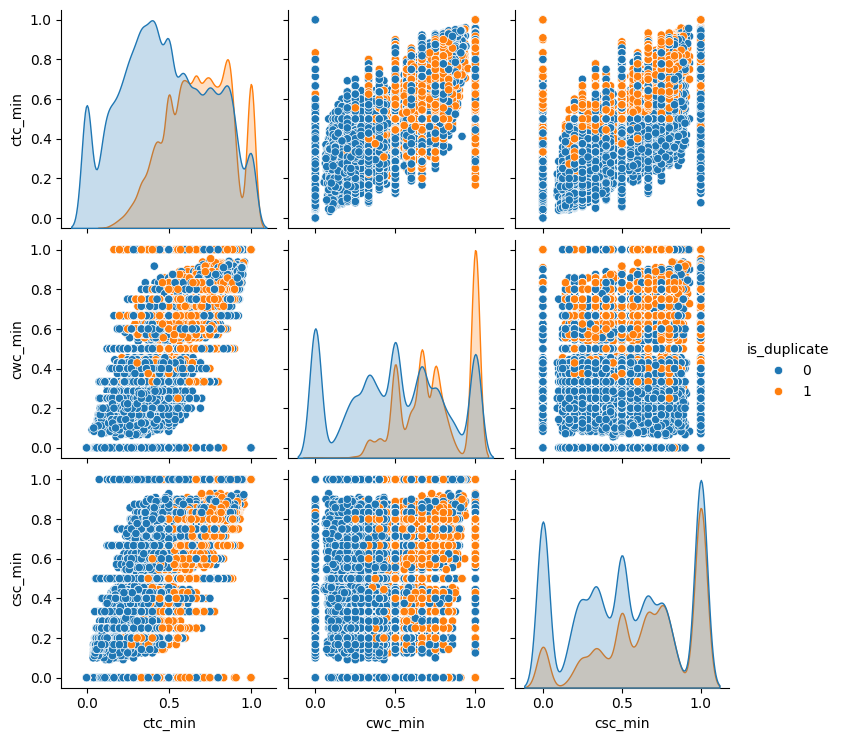

In [ ]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

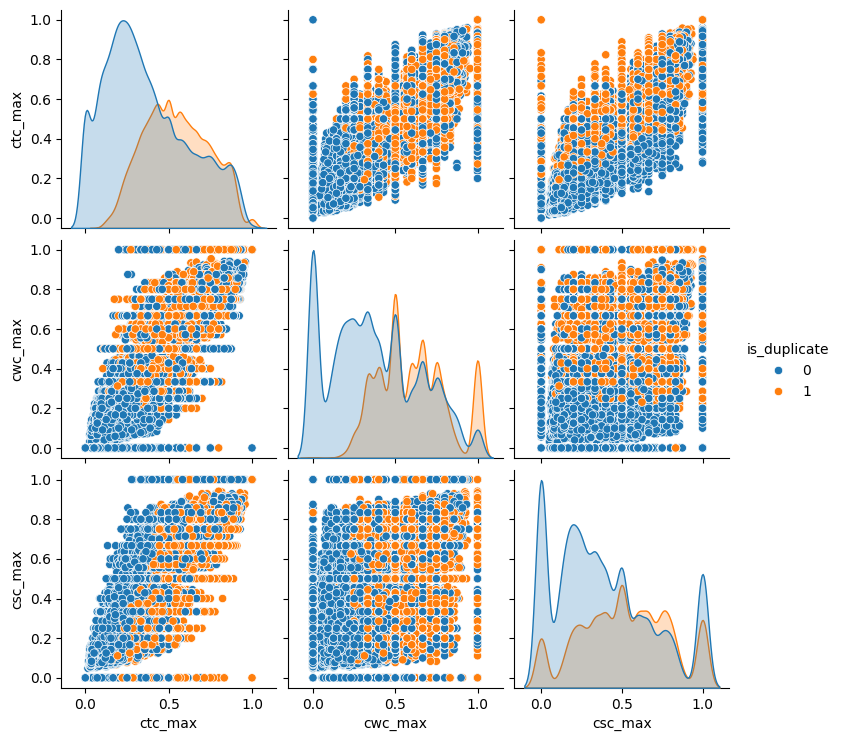

In [ ]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

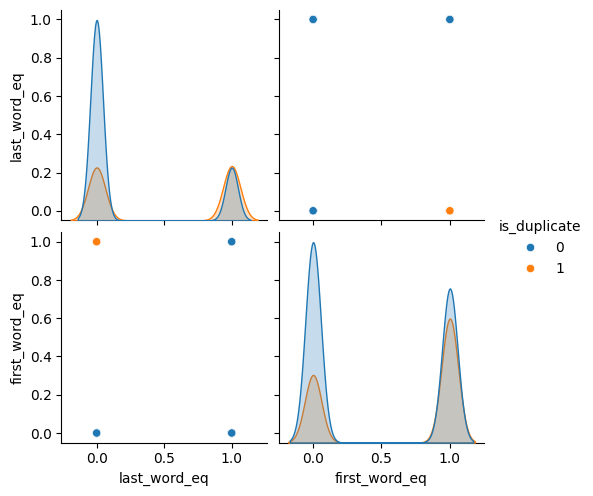

In [ ]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

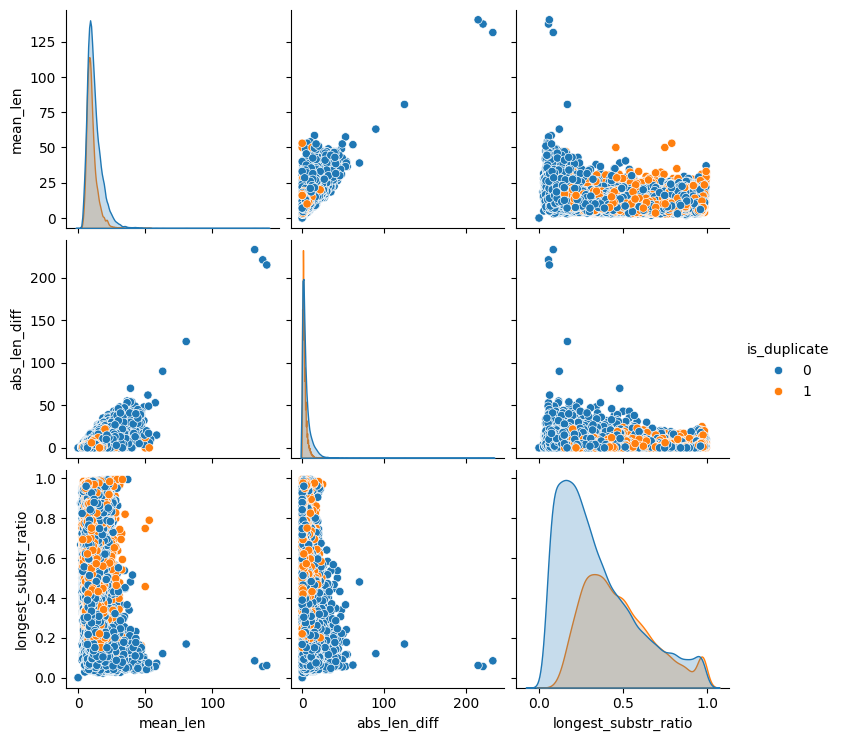

In [ ]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

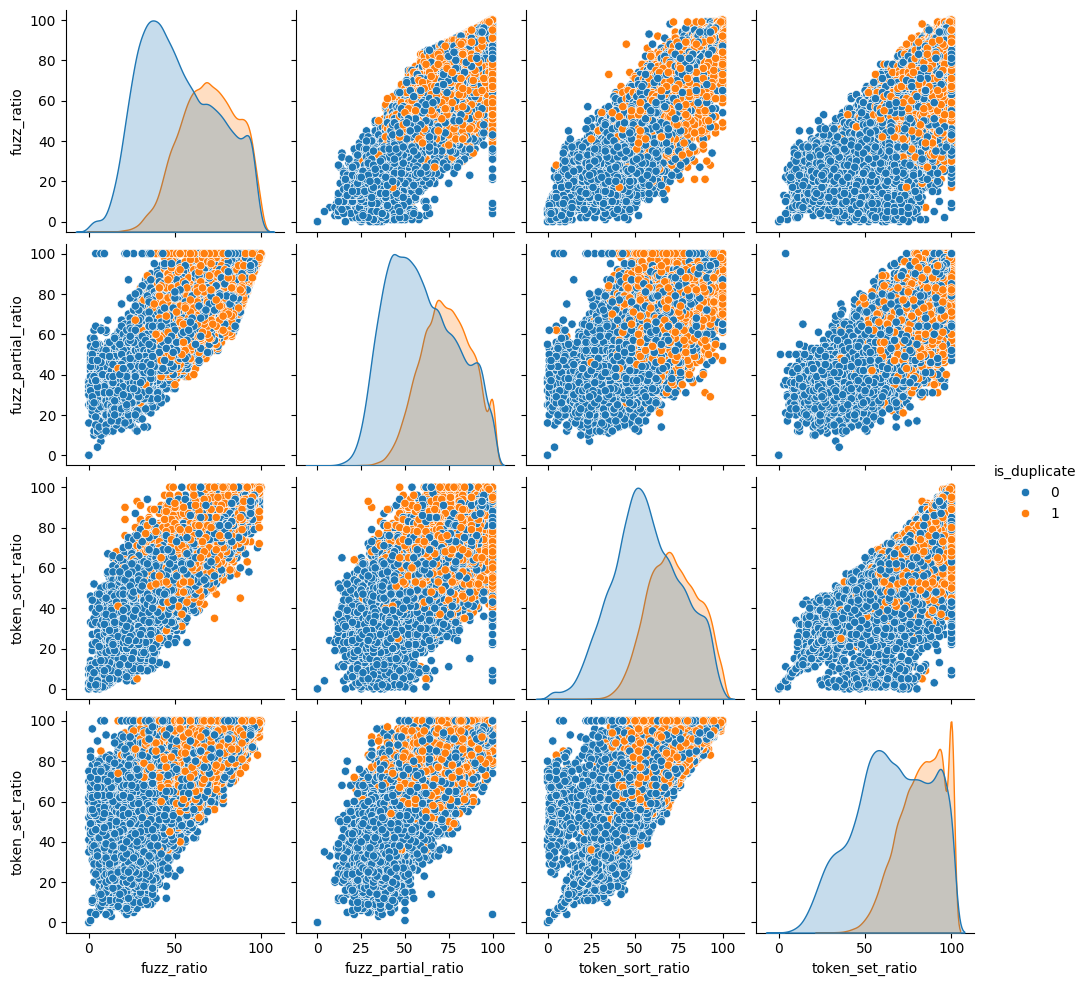

In [ ]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [ ]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

In [ ]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 79999 samples in 0.186s...
[t-SNE] Computed neighbors for 79999 samples in 25.406s...
[t-SNE] Computed conditional probabilities for sample 1000 / 79999
[t-SNE] Computed conditional probabilities for sample 2000 / 79999
[t-SNE] Computed conditional probabilities for sample 3000 / 79999
[t-SNE] Computed conditional probabilities for sample 4000 / 79999
[t-SNE] Computed conditional probabilities for sample 5000 / 79999
[t-SNE] Computed conditional probabilities for sample 6000 / 79999
[t-SNE] Computed conditional probabilities for sample 7000 / 79999
[t-SNE] Computed conditional probabilities for sample 8000 / 79999
[t-SNE] Computed conditional probabilities for sample 9000 / 79999
[t-SNE] Computed conditional probabilities for sample 10000 / 79999
[t-SNE] Computed conditional probabilities for sample 11000 / 79999
[t-SNE] Computed conditional probabilities for sample 12000 / 79999
[t-SNE] Computed conditional probabilities for sa

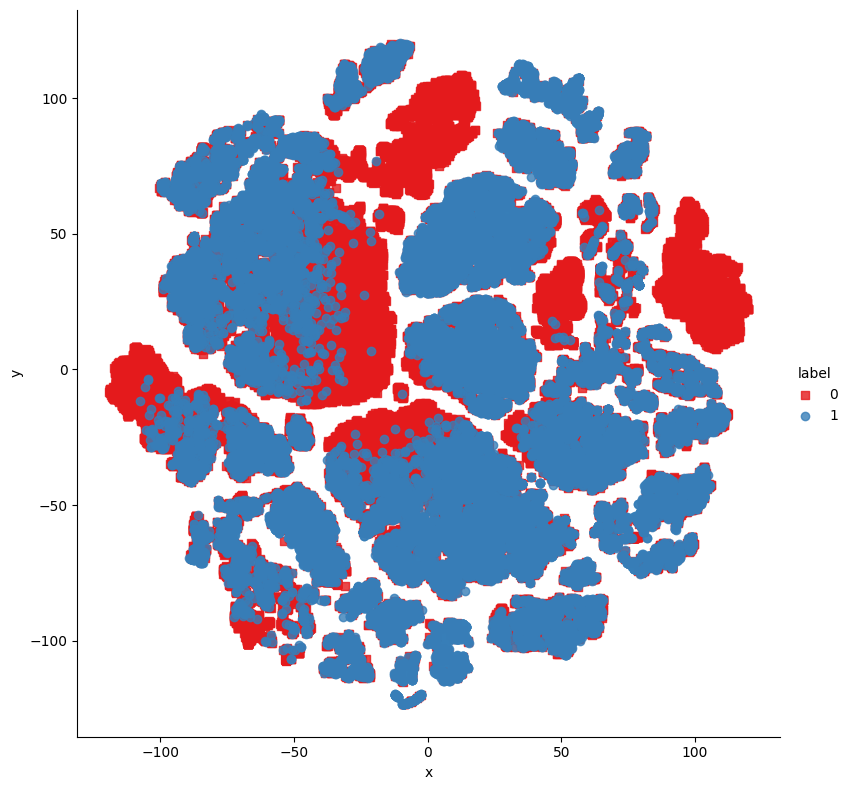

In [ ]:
x_df = pd.DataFrame({'x':tsne2d[:,0], #All rows, column 0 → X-axis coordinate
                     'y':tsne2d[:,1] , #All rows, column 1 → Y-axis coordinate
                     'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, # the dataframe to use
           x='x', y='y', # plot 2d tsne coordinates
           hue='label', # colour points by the label (0 or 1)
           fit_reg=False, # dont draw a regression line,just plot
           height=8, # figure size
           palette="Set1" #set of distinct colours
           ,markers=['s','o']) #shape for class 0= square and class 1=circle

In [ ]:
sentences = [q.split() for q in pd.concat([new_df['question1'], new_df['question2']])]

In [ ]:
from gensim.models import Word2Vec

In [ ]:
w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=5, workers=4)

In [ ]:
import numpy as np

def question_to_vec(question, model, vector_size):
    words = question.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vecs, axis=0)

# Apply to each question
q1_vectors = np.vstack(new_df['question1'].apply(lambda x: question_to_vec(x, w2v_model, 300)))
q2_vectors = np.vstack(new_df['question2'].apply(lambda x: question_to_vec(x, w2v_model, 300)))

In [ ]:
X = np.hstack((q1_vectors, q2_vectors, np.abs(q1_vectors - q2_vectors)))
y = new_df['is_duplicate'].values

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Split your Word2Vec feature set and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import joblib
import os

# Step 1: Define model with smaller size goal
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Step 2: Reduced hyperparameter space
rf_params = {
    'n_estimators': [50, 100],         # ↓ fewer trees
    'max_depth': [5, 10],              # ↓ shallower trees
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Step 3: Perform randomized search
rf_random = RandomizedSearchCV(
    rf, rf_params,
    n_iter=8,         # 8 combinations (less compute)
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Step 4: Fit on training data
rf_random.fit(X_train, y_train)

# Step 5: Save best model with compression
best_rf = rf_random.best_estimator_
joblib.dump(best_rf, "rf_model_compressed.pkl", compress=3)

# Step 6: Report file size
model_size = os.path.getsize("rf_model_compressed.pkl") / 1024 / 1024
print(f"✅ Compressed model saved: rf_model_compressed.pkl ({model_size:.2f} MB)")

# Optional: Check accuracy on test data
y_pred = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Compressed model saved: rf_model_compressed.pkl (2.80 MB)
Test Accuracy: 0.7235625


In [ ]:
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    n_iter=10,                # Only 10 random combos instead of full grid
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

xgb_random.fit(X_train, y_train)

# Best model
best_xgb = xgb_random.best_estimator_

# Evaluation
y_pred_xgb = best_xgb.predict(X_test)

print("🔍 XGBoost Best Params:", xgb_random.best_params_)
print("🎯 XGB Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
🔍 XGBoost Best Params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
🎯 XGB Accuracy: 0.755125
              precision    recall  f1-score   support

           0       0.77      0.87      0.82     10089
           1       0.71      0.56      0.63      5911

    accuracy                           0.76     16000
   macro avg       0.74      0.72      0.72     16000
weighted avg       0.75      0.76      0.75     16000



In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Step 6: Predict on test data
y_pred_rf = best_rf.predict(X_test)

# Step 7: Accuracy
print("🎯 Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Step 8: Classification Report
print("📊 Classification Report:\n", classification_report(y_test, y_pred_rf))

🎯 Random Forest Accuracy: 0.7235625
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.93      0.81     10089
           1       0.76      0.37      0.50      5911

    accuracy                           0.72     16000
   macro avg       0.74      0.65      0.65     16000
weighted avg       0.73      0.72      0.69     16000



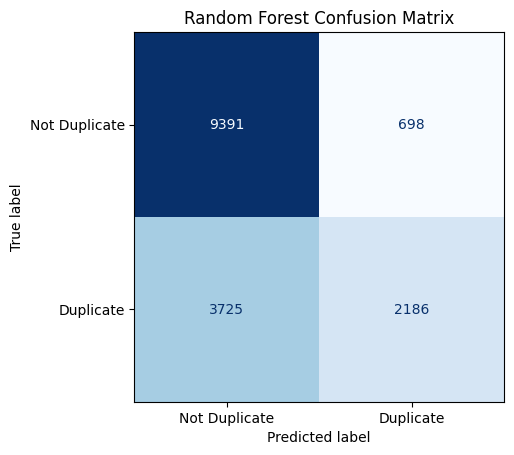

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report
# 1. Random Forest Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_rf,
    X_test,
    y_test,
    display_labels=["Not Duplicate", "Duplicate"],
    cmap='Blues',
    colorbar=False
)
plt.title("Random Forest Confusion Matrix")
plt.grid(False)
plt.show()

🎯 XGB Accuracy: 0.755125
              precision    recall  f1-score   support

           0       0.77      0.87      0.82     10089
           1       0.71      0.56      0.63      5911

    accuracy                           0.76     16000
   macro avg       0.74      0.72      0.72     16000
weighted avg       0.75      0.76      0.75     16000



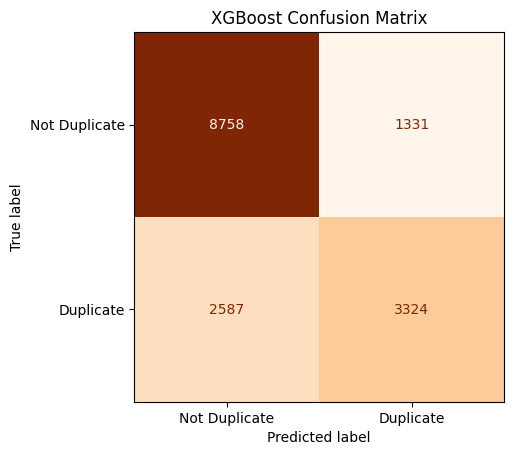

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

print("🎯 XGB Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
# 2. XGBoost Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_xgb,
    X_test,
    y_test,
    display_labels=["Not Duplicate", "Duplicate"],
    cmap='Oranges',
    colorbar=False
)
plt.title("XGBoost Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
import joblib

#joblib.dump(best_rf, 'random_forest_model.pkl')
joblib.dump(best_xgb, 'xgboost_model.pkl')
joblib.dump(w2v_model, 'word2vec_model.pkl')

['word2vec_model.pkl']

In [1]:
from google.colab import files
files.download('rf_model_compressed.pkl')
files.download('xgboost_model.pkl')
files.download('word2vec_model.pkl')

FileNotFoundError: Cannot find file: rf_model_compressed.pkl